<a href="https://colab.research.google.com/github/URBAN-IA/URBANIA/blob/main/study/ml/%EC%84%9C%EC%9A%B8_%EC%A0%84%EA%B8%B0%EC%9E%90%EC%A0%84%EA%B1%B0_%EC%88%98%EC%9A%94_%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습5.서울 전기자전거 수요 예측하기

```
실습목표
1. 데이터셋을 불러와서 모델에 입력가능하도록 변경합니다. (범주형, 수치형 따로)
2. 랜덤 포레스트 모델을 불러와서 학습시킵니다.
3. 모델을 학습시키고 평가합니다.

```



```
실습단계
1. 라이브러리 임포트
2. 데이터셋 로드
3. 데이터 전처리 (preprocessing)
4. 모델 로드 및 학습
5. 모델 평가 및 예측
6. 결과 시각화

```


###1.라이브러리 임포트

먼저, 데이터 분석과 모델링을 위해 필요한 라이브러리를 불러옵니다. <br> 주로 pandas, numpy, sklearn, 등을 사용합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

- pandas: 데이터를 쉽게 다루기 위한 라이브러리로, 주로 테이블 형태의 데이터를 다루는 데 사용되며, `데이터프레임(DataFrame)과 시리즈(Series)와 같은 데이터 구조를 제공`합니다.

- numpy: `다차원 배열을 쉽게 처리할 수 있도록 지원하는 Python 라이브러리`입니다. 과학 계산을 위한 다양한 기능을 제공하며, 대규모 다차원 배열과 행렬 연산에 필수적이며, 이러한 배열을 조작하기 위한 높은 수준의 수학 함수를 제공합니다.

- torch : Pytorch 의 기본 패키지로, 다차원 배열을 효율적으로 처리할 수 있는 텐서(tensor) 데이터 구조 및 다양한 수학 연산을 제공합니다. `딥러닝 모델 설계와 학습을 위한 프레임워크로, 동적 계산 그래프를 지원`하여 모델 설계가 직관적이고 유연합니다.

- torch.nn : `신경망을 구축하기 위한 다양한 레이어와 함수를 제공`합니다. 이를 통해 쉽게 딥러닝 모델을 구성하고, 손실 함수(loss functions), 활성화 함수(activation functions) 등을 사용할 수 있습니다.

- train_test_split: 데이터를 `훈련 세트와 테스트 세트로 분리해주는 함수`로, 모델의 성능을 검증할 때 사용됩니다.

- MinMaxScaler : 사이킷런의 전처리(preprocessing) 모듈에 포함된 클래스로, 특성 데이터의 스케일을 조정합니다. 데이터의 최소값과 최대값을 사용하여 `지정된 범위(기본적으로 0과 1 사이)로 데이터를 정규화`합니다. 이는 모델 학습의 성능을 향상시키는 데 도움이 됩니다.

### 2.데이터 로드

[자전거 대여 수요 데이터](https://www.kaggle.com/datasets/saurabhshahane/seoul-bike-sharing-demand-prediction)를 kaggle 에서 불러와 기본적인 데이터 구조를 확인합니다. <br> 데이터를 탐색하여 누락된 값이나 이상치가 있는지 확인하고, 데이터의 분포를 파악합니다.

- 혹시 불러오지 못한 분들은 [이 링크](https://drive.google.com/file/d/13W9laYG90nF5aPLwbjsTHeHKyQuUei57/view?usp=sharing)에서 다운로드 해주세요.

In [ ]:
import gdown
file_id = "13W9laYG90nF5aPLwbjsTHeHKyQuUei57"
output = "/content/SeoulBikeData.csv" # 저장 위치 및 저장할 파일 이름
gdown.download(id=file_id, output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=13W9laYG90nF5aPLwbjsTHeHKyQuUei57
To: /content/SeoulBikeData.csv
100%|██████████| 604k/604k [00:00<00:00, 91.6MB/s]


'/content/SeoulBikeData.csv'

In [ ]:
# 데이터 불러오기
try:
    data = pd.read_csv('/content/SeoulBikeData.csv',encoding='utf-8') # 여기에 데이터셋의 경로를 지정해주세요.
except UnicodeDecodeError:
    # UTF-8로 실패할 경우 CP949로 재시도
    data = pd.read_csv('/content/SeoulBikeData.csv',encoding='cp949')

In [ ]:
# 데이터 상위 5행 확인
data.head()

,Date,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
# 데이터의 전체 열(column) 확인
data.__

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(캜)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(캜)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

```
['Date', 'Rented Bike Count', 'Hour', 'Temperature(캜)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(캜)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day']
```


In [ ]:
# dtype 및 결측치 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(캜)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(캜)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

In [ ]:
# 데이터 기술 통계 확인
data.describe()

,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


- `pd.read_csv()`: CSV 파일을 읽어와 pandas의 DataFrame 형태로 데이터를 불러옵니다. 여기서는 `'your_dataset.csv'`를 자신의 데이터셋 경로로 변경해야 합니다.
- `data.head()`: 데이터프레임의 상위 5행을 출력하여, 데이터의 구조와 초기 몇 개의 데이터를 빠르게 살펴볼 수 있습니다.
- `data.columns` : 데이터프레임(DataFrame)의 컬럼들을 출력합니다.
- `data.info()` : 데이터프레임(DataFrame)의 결측치와 데이터타입을 확인합니다.
- `data.describe()`: 데이터의 기술 통계 정보를 요약하여 보여줍니다. 수치형 컬럼에 대한 평균, 표준편차, 최소값, 최대값 등을 확인할 수 있습니다.

In [ ]:
# 파일 인코딩 방식 차이로 인한 오류 보정
data["Temperature(kyung)"] = data[__]
data["Dew point temperature(kyung)"] = data[__]

data.drop(["Temperature(캜)","Dew point temperature(캜)"],axis=1,inplace=True)

### 3.데이터 전처리(preprocessing)

- 데이터 전처리 과정에서는 누락된 값을 처리하고, 필요한 경우 범주형 변수를 원-핫 인코딩으로 변환하며, 수치형 데이터를 정규화합니다.

- 데이터를 학습 세트와 테스트 세트로 분리하여 모델의 성능을 검증할 수 있게 합니다.

In [ ]:
data.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
       'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day',
       'Temperature(kyung)', 'Dew point temperature(kyung)'],
      dtype='object')

In [ ]:
data.head()

,Date,Rented Bike Count,Hour,Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Temperature(kyung),Dew point temperature(kyung)
0,01/12/2017,254,0,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,-5.2,-17.6
1,01/12/2017,204,1,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,-5.5,-17.6
2,01/12/2017,173,2,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,-6.0,-17.7
3,01/12/2017,107,3,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,-6.2,-17.6
4,01/12/2017,78,4,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Yes,-6.0,-18.6


In [ ]:
# 누락된 값 처리
data.fillna(method='ffill', inplace=True)

# 'Date' 컬럼을 datetime 타입으로 변환하고, 연, 월, 일로 분리
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

In [ ]:
# 원본 'Date' 컬럼은 이제 제거
data.drop('Date', axis=1, inplace=True)

# 범주형 변수 원-핫 인코딩
data = pd.get_dummies(data, columns=['Seasons', 'Holiday', 'Functioning Day'])

# 정규화가 필요한 수치형 컬럼 선택
numerical_features = __

# MinMaxScaler를 사용하여 정규화
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[__])

- `fillna()`: 누락된 데이터를 채우기 위해 사용합니다. 여기서는 'ffill' 방식을 사용해 이전 값으로 누락된 값을 채웁니다.
- `pd.get_dummies()`: 범주형 변수를 원-핫 인코딩으로 변환합니다. 모델이 범주형 데이터를 이해할 수 있도록 수치형 데이터로 변환하는 과정입니다.
- `MinMaxScaler()`: 데이터의 특성 값의 범위를 [0, 1]로 조정하여 모든 특성이 동일한 스케일을 갖도록 합니다. 이는 모델의 성능을 향상시키는 데 도움이 됩니다.

In [ ]:
X = __ # 'Rented Bike Count' 열을 제외한 모든 특성을 사용
y = data['Rented Bike Count'] # 예측 목표 변수

# 데이터를 훈련 세트와 테스트 세트로 분리
__ = train_test_split(X, y, test_size=0.2, random_state=42)

- `data.drop()`: 'Rented Bike Count' 열(타겟 변수)을 제외한 데이터를 특성 변수로 사용합니다.
- `train_test_split()`: 데이터를 훈련 세트와 테스트 세트로 분리합니다. test_size=0.2는 전체 데이터의 20%를 테스트 세트로 사용하겠다는 의미입니다.


### 4. 모델 로드 및 학습

In [ ]:
# 랜덤 포레스트 회귀 모델을 생성합니다.
model = __

In [ ]:
# 모델을 훈련 데이터에 적합시킵니다.
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 5.모델 평가 및 예측

In [ ]:
# 예측
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [ ]:
# 성능 평가
train_mse = __
test_mse = __
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MSE: {train_mse}, Train R^2: {train_r2}')
print(f'Test MSE: {test_mse}, Test R^2: {test_r2}')

Train MSE: 0.0005679998438305703, Train R^2: 0.9827264795573368
Test MSE: 0.004480697085711862, Test R^2: 0.8640116749037364


### 6.결과 시각화

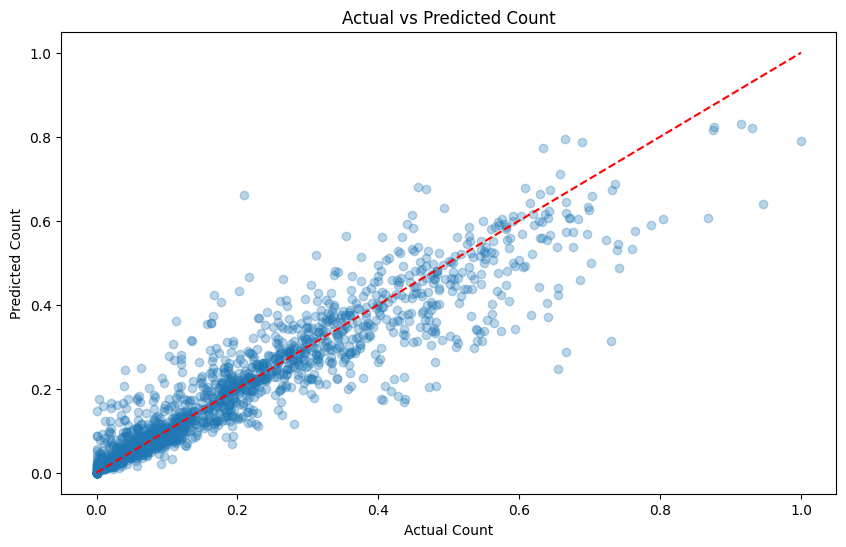

In [ ]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.title('Actual vs Predicted Count')
plt.show()